## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet

## Importar dataset

In [4]:
df = pd.read_csv('data/ts_beer.csv')

In [5]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [6]:
df.tail()

,Month,Monthly beer production
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [7]:
df.shape

(476, 2)

In [8]:
df.columns.to_list()

['Month', 'Monthly beer production']

In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly beer production,476.0,136.395378,33.738725,64.8,112.9,139.15,158.825,217.8


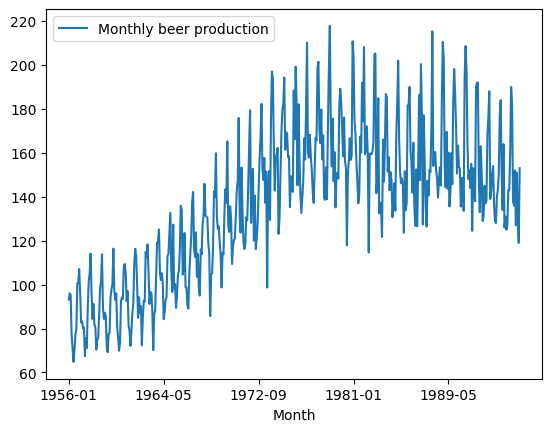

In [14]:
df.set_index('Month').plot();